In [122]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, basename
from glob import glob
import pickle
from scipy.stats import pearsonr
from scipy.signal import periodogram, filtfilt, spectrogram
import seaborn as sns
import xarray as xr
import matplotlib as mpl
from matplotlib.lines import Line2D

from filtering import freq_filt
from cb91visuals import *
sns.set(font='Arial',
        rc={
 'axes.axisbelow': True,
 'axes.edgecolor': 'grey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.grid.axis':'y',
 'axes.labelcolor': 'black',
 'axes.linewidth': 1,
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'lightgrey',
 'figure.figsize': (18, 12),
 'grid.color': 'grey',
 'grid.alpha':1,
 'grid.linewidth':0.5,
 'image.aspect':'auto',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'savefig.dpi':300,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'grey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'grey',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.color':'grey',
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":26,
                                "axes.labelsize":16})

In [2]:
data_dir = '/bsuscratch/zacharykeskinen/data/infrasound/array_data'

with open(join(data_dir, 'merged/all_days'), 'rb') as f:
    days = pickle.load(f)
sps = 200

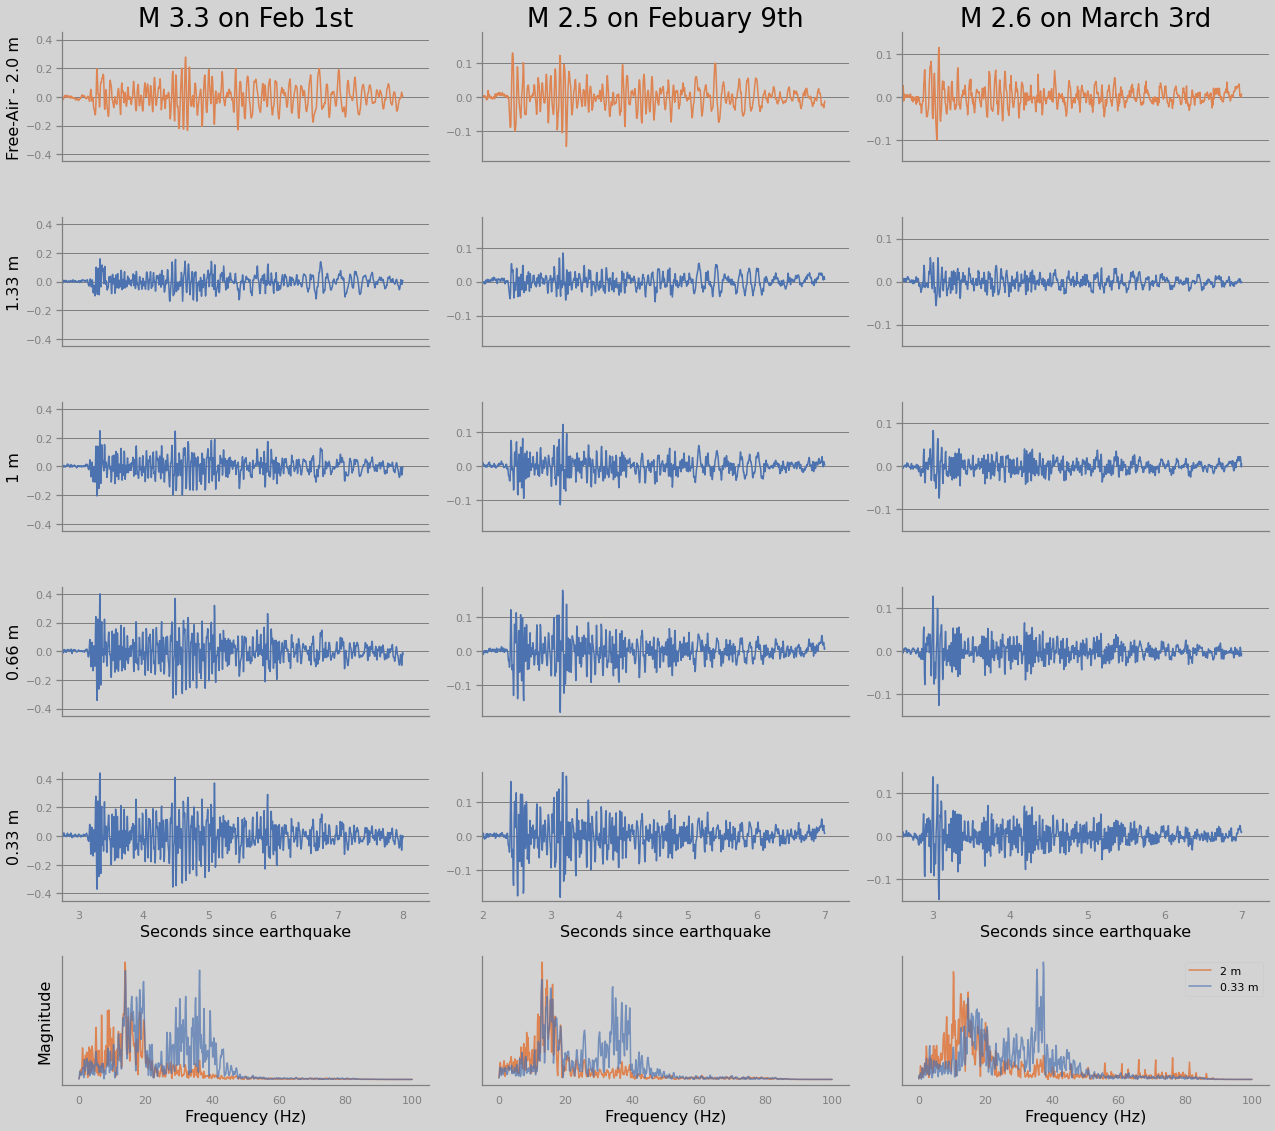

In [123]:
hs = [2, 1.33, 1, 0.66, 0.33]
eqs = {0: {'day':'2022-02-01','hour': 9,'smin': 43,'ssec': 6.590,'emin': 43,'esec': 15,'ylim': 0.45, 'id': 'us7000ggx4', 'title':'M 3.3 on Feb 1st'},\
    1: {'day':'2022-02-09','hour': 9,'smin': 56,'ssec': 27.412,'emin': 56,'esec': 34.5,'ylim': 0.19, 'id': 'us7000gjaw', 'title': 'M 2.5 on Febuary 9th'},\
    2: {'day':'2022-03-03','hour': 15,'smin': 17,'ssec': 22.106,'emin': 17,'esec': 30,'ylim': 0.15, 'id': 'us6000h1ql', 'title':'M 2.6 on March 3rd'}}

f, axes = plt.subplots(6, len(eqs), figsize = (18,16))

for i, eq_d in eqs.items():
    locals().update(eq_d)
    s = f'{day} T{hour}:{smin}:{ssec}'
    e = f'{day} T{hour}:{emin}:{esec}'
    t_delta = pd.to_datetime(e) - pd.to_datetime(s)
    for j, h in enumerate(hs):
        ax = axes[j, i]
        da = pd.read_parquet(days[day][h])
        hour = 9
        sub = da.loc[(da.index > s) & (da.index < e), 'pa']
        ser = pd.Series(freq_filt(sub.values, 1, 'highpass', 1), np.linspace(0, t_delta.seconds, len(sub)))
        if h == 2:
            sns.lineplot(data = ser, ax = ax, color = 'C1')
        else:
            sns.lineplot(data = ser, ax = ax)
        if i == 0:
            if j != 0:
                ax.set_ylabel(f'{h} m')
            else:
                ax.set_ylabel('Free-Air - 2.0 m')
        if j == 0:
            ax.set_title(title)
        if j != 4:
            ax.set_xticks([])
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Seconds since earthquake')
        ax.set_ylim(-ylim, ylim)
        if i == 0:
            ax.set_xlim(left = 2.75)
        elif i == 2:
            ax.set_xlim(left = 2.6)
        else:
            ax.set_xlim(left = 2)
        if h == 0.33:
            axes[5, i].magnitude_spectrum(ser, Fs = 200, scale = 'linear', label = f'{h} m', color = 'C0', alpha = 0.7) 
        elif h == 2:
            axes[5, i].magnitude_spectrum(ser, Fs = 200, scale = 'linear', label = f'{h} m', color = 'C1')
    if i != 0:
        axes[5, i].set_ylabel('')
    else:
        axes[5,i].set_ylabel('Magnitude')
    if i == 2:
        handles, labels = axes[-1,-1].get_legend_handles_labels()
        axes[-1,-1].legend(handles, labels, loc='best')
    axes[5,i].set_yticks([])
    axes[5,i].set_xlabel('Frequency (Hz)')
plt.tight_layout()
fig_dir = '/bsuhome/zacharykeskinen/infrasound/figures'
# plt.savefig(join(fig_dir, 'signal_compares', 'multieq_example_v2.png'), dpi = 300)